### 1. 필요 모듈 선언

In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
 
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os

### 2. CIFAR 훈련, 테스트 데이터셋 다운로드
- 32*32
    - airplane										
    - automobile										
    - bird										
    - cat										
    - deer										
    - dog										
    - frog										
    - horse										
    - ship										
    - truck										


In [2]:
#dataset.MNIST 를 사용해서 MNIST 데이터셋을 다운받을 수 있다. train 은 훈련데이터 여부, download는 기존에 없다면 root 경로에 다운로드)
train_dataset = datasets.CIFAR10(root='/home/yunseo/notebooks/deeplearning_practice/data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='/home/yunseo/notebooks/deeplearning_practice/data', train=False, transform=transforms.ToTensor()) #코드가 비슷해보여도 train이 False여서 이건 test 데이터가 다운로드 됨!

100%|██████████| 170498071/170498071 [01:36<00:00, 1763745.70it/s]


Extracting /home/yunseo/notebooks/deeplearning_practice/data/cifar-10-python.tar.gz to /home/yunseo/notebooks/deeplearning_practice/data


### 3. 데이터 확인

Target: automobile
Size of Image: (32, 32, 3)


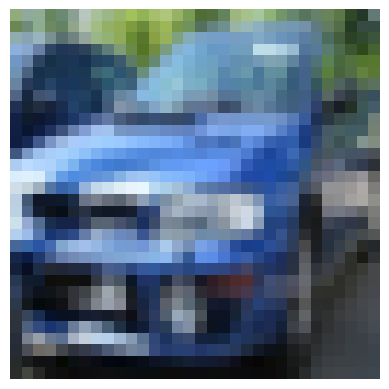

In [7]:
torch.manual_seed(70)

idx = torch.randint(0, len(train_dataset), (1,)).item()
random_img = train_dataset[idx][0].squeeze().permute(1,2,0).numpy()
target_num = train_dataset[idx][1]

label = {0:"airplane",
         1:"automobile",
         2:"bird",
         3:"cat",
         4:"deer",
         5:"dog",
         6:"frog",
         7:"horse",
         8:"ship",
         9:"truck"}

print("Target: {}".format(label[target_num]))
print("Size of Image: {}".format(random_img.shape))

plt.imshow(random_img)
plt.axis('off')
plt.show()

### 4. 데이터 로더 정의, 확인

In [8]:
len(train_dataset)

50000

In [9]:
BATCH = 64 #미니배치의 크기. 한번에 얼마나 많은 양의 이미지를 학습시킬건지
DEVICE = 'cpu'
STEP =10

train_set, val_set = torch.utils.data.random_split(train_dataset, [40000, 10000])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH, shuffle=True)
val_loader= DataLoader(dataset=val_set, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH, shuffle=False)

In [10]:
for (data, target) in train_loader:
    print(data.size(), target.size())
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])


### 5. 모델 정의

In [34]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_ih = nn.Linear(input_size, hidden_size)
        self.linear_hh = nn.Linear(hidden_size, hidden_size)
        self.linear_ho = nn.Linear(hidden_size, output_size)
        self.activation_layer = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_ih(x)
        x = self.activation_layer(x)
        x = self.linear_hh(x)
        x = self.activation_layer(x)
        y = self.linear_ho(x)
        return y

In [35]:
model = Net(input_size=3*32*32, hidden_size=100, output_size=10).to(DEVICE)

### 6. 손실함수 및 옵티마이저 정의, 파라미터 확인

In [28]:
#옵티마이저에는 모델에 내장되어있는 모든 매개변수를 인자로 전달해줘야한다.

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_params = 0 #모델에 사용되는 파라미터 확인위한 초기화
for params in model.parameters():
    num_params += params.view(-1).size(0)
print('모델 파라미터 총 개수: {}'.format(num_params))

모델 파라미터 총 개수: 318410


### 7. 학습 및 테스트에 필요한 함수 정의
- train 함수는 한 스텝 동안 발생하는 학습 과정
- test 함수는 테스트 데이터로 모델의 성능을 결정하는 함수

In [29]:
def train(model,train_loader, loss_func, optimizer, step, device, print_step=200):
    """train function: 1 스텝 동안 발생하는 학습 과정"""
    model.train() #모델한테 훈련단계라고 선언
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) #입력과 타겟을 동일한 디바이스에 올려줘야 됨

        #forward
        model.zero_grad() #경사 초기화
        output = model(data)
        loss = loss_func(output, target)

        #backward
        loss.backward()
        optimizer.step()

        if batch_idx % print_step ==0:
            print('Train Step: {} ({:05.2f}%) \tLoss: {:.4f}' .format(step, 100.*(batch_idx*train_loader.batch_size)/len(train_loader.dataset), loss.item()))


def test(model, val_loader, loss_func, device):
    model.eval()
    val_loss=0
    correct=0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_func(output, target, reduction="sum").item()
            pred = output.softmax(1).argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() #item은 텐서를 int로 변환
        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:05.2f}%'.format(val_loss, correct, len(val_loader.dataset), 100. *val_acc))
        return val_loss, val_acc

def main(model, train_loader, val_loader, loss_func, optimizer, n_step, device, save_path, print_step):
    val_accs = []
    best_acc = 0.0

    for step in range(1, n_step+1):
        train(model, train_loader, loss_func, optimizer, step=step, device=device, print_step=print_step)
        val_loss, val_acc =test(model, val_loader, loss_func=F.cross_entropy, device=device)

        val_accs.append(val_acc)
        if len(val_accs) >= 2:
            if val_acc >=best_acc:
                best_acc = val_acc
                best_state_dict = model.state_dict()
                print("discard previous state, best model state saved!")
        print("")

    torch.save(best_state_dict, save_path)

### 8. 학습 시작

In [30]:
main (model=model,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_func=loss_function,
      optimizer=optimizer,
      n_step=STEP,
      device=DEVICE,
      save_path="cifar10_model.pt",
      print_step=200)

Train Step: 1 (00.00%) 	Loss: 2.2918
Train Step: 1 (32.00%) 	Loss: 1.8545
Train Step: 1 (64.00%) 	Loss: 1.8224
Train Step: 1 (96.00%) 	Loss: 1.6865
Val set: Average loss: 1.8106, Accuracy: 3518/10000 (35.18%

Train Step: 2 (00.00%) 	Loss: 1.7608
Train Step: 2 (32.00%) 	Loss: 1.7611
Train Step: 2 (64.00%) 	Loss: 1.6628
Train Step: 2 (96.00%) 	Loss: 1.3790
Val set: Average loss: 1.6801, Accuracy: 3994/10000 (39.94%
discard previous state, best model state saved!

Train Step: 3 (00.00%) 	Loss: 1.6580
Train Step: 3 (32.00%) 	Loss: 1.6154
Train Step: 3 (64.00%) 	Loss: 1.5123
Train Step: 3 (96.00%) 	Loss: 1.5630
Val set: Average loss: 1.6147, Accuracy: 4227/10000 (42.27%
discard previous state, best model state saved!

Train Step: 4 (00.00%) 	Loss: 1.4886
Train Step: 4 (32.00%) 	Loss: 1.5853
Train Step: 4 (64.00%) 	Loss: 1.5061
Train Step: 4 (96.00%) 	Loss: 1.7375
Val set: Average loss: 1.6107, Accuracy: 4230/10000 (42.30%
discard previous state, best model state saved!

Train Step: 5 (00.00

### 9. test loader로 확인

Predicted: airplane
Target: deer
 
Misclassification...


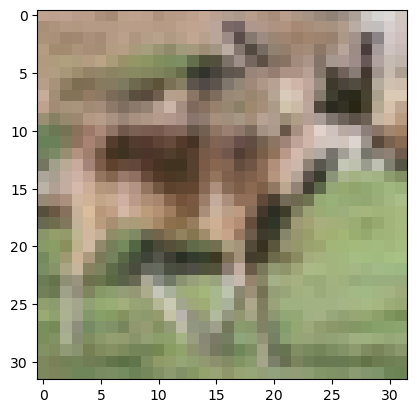

In [71]:
# torch.manual_seed(70)

idx = torch.randint(0, len(test_dataset), (1,)).item()

random_img = test_dataset[idx][0].unsqueeze(0) 
target_num = test_dataset[idx][1]

label = {0:"airplane",
         1:"automobile",
         2:"bird",
         3:"cat",
         4:"deer",
         5:"dog",
         6:"frog",
         7:"horse",
         8:"ship",
         9:"truck"}

model.eval()

pred = model(random_img) 

plt.imshow(random_img.squeeze().permute(1,2,0))
print("Predicted: {}".format(label[pred.softmax(1).argmax().item()]))
print("Target: {}".format(label[target_num]))
print(" ")
if target_num == pred.softmax(1).argmax().item() :
    print("Prediction succeeded!")

else:
    print("Misclassification...")